In [5]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [7]:
import os
import time
import uuid 
import cv2

In [27]:
IMAGES_PATH = '/mnt/c/data/images'
number_images = 30

In [35]:
import cv2

# Initialize the camera (try different indices if needed)
cap = cv2.VideoCapture(0, cv2.CAP_V4L2)  # Force V4L2 backend

# Set camera properties (adjust as needed)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M','J','P','G'))  # MJPEG format
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()   

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2025-04-06 12:54:13.039901: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 12:54:13.238661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743940453.312236     816 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743940453.332420     816 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743940453.482326     816 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
images = tf.data.Dataset.list_files('/mnt/c/data/images/*.jpg', shuffle=False)

I0000 00:00:1743777856.318523     679 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
images.as_numpy_iterator().next()

b'/mnt/c/data/images/23560bac-114c-11f0-8cc5-00155d4acf83.jpg'

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [77]:
images.as_numpy_iterator().next()

2025-04-04 21:48:19.862127: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: /mnt/c/data/images/26b622cb-114c-11f0-b95f-00155d4acf83.jpg; No such file or directory
2025-04-04 21:48:19.862157: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: /mnt/c/data/images/257c45e8-114c-11f0-a051-00155d4acf83.jpg; No such file or directory
2025-04-04 21:48:19.862176: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: /mnt/c/data/images/261847d1-114c-11f0-8fcf-00155d4acf83.jpg; No such file or directory
2025-04-04 21:48:19.862197: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_file_read_ops.cc:117 : NOT_FOUND: /mnt/c/data/images/2666ed97-114c-11f0-981f-00155d4acf83.jpg; No such file or directory
2025-04-04 21:48:19.862224: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at whole_f

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to MapDataset:2 transformation with iterator: Iterator::Root::ParallelMapV2: /mnt/c/data/images/23560bac-114c-11f0-8cc5-00155d4acf83.jpg; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext] name: 

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [16]:
plot_images = image_generator.next()

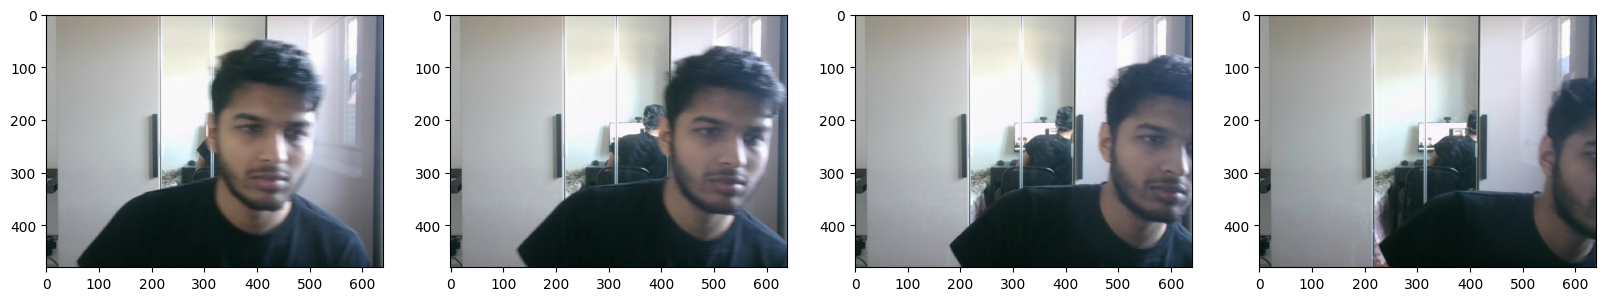

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [22]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('/mnt/c/data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('/mnt/c/data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('/mnt/c/data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [24]:
import albumentations as alb

In [25]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params = alb.BboxParams(format='albumentations',
                                                      label_fields=['class_labels']))

In [27]:
img = cv2.imread(os.path.join('/mnt/c/data/train/images', '2a15b3a5-114c-11f0-ad74-00155d4acf83.jpg'))

In [34]:
img.shape

(480, 640, 3)

In [29]:
with open(os.path.join('/mnt/c/data/train/labels', '2a15b3a5-114c-11f0-ad74-00155d4acf83.json'), 'r') as f:
    label = json.load(f)

In [37]:
label['shapes'][0]['points']

[[4.25925925925928, 64.07407407407413],
 [219.07407407407408, 418.7037037037037]]

In [40]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [41]:
coords

[4.25925925925928, 64.07407407407413, 219.07407407407408, 418.7037037037037]

In [42]:
coords = list(np.divide(coords, [640, 480, 640, 480]))

In [43]:
coords

[np.float64(0.006655092592592625),
 np.float64(0.13348765432098778),
 np.float64(0.34230324074074076),
 np.float64(0.8722993827160493)]

In [44]:
augmented = augmentor(image = img, bboxes=[coords], class_labels=['face'])

In [48]:
augmented['bboxes'][0]

[0.5220576053195529,
 0.08732511308458113,
 0.9994238679938846,
 0.875390943951077]

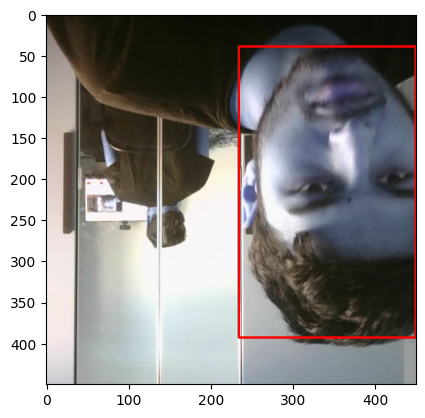

In [51]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
                    (255,0,0), 2)
plt.imshow(augmented['image'])

In [54]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('/mnt/c/data', partition, 'images')):
        img = cv2.imread(os.path.join('/mnt/c/data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('/mnt/c/data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

                coords[0] = label['shapes'][0]['points'][0][0]
                coords[1] = label['shapes'][0]['points'][0][1]
                coords[2] = label['shapes'][0]['points'][1][0]
                coords[3] = label['shapes'][0]['points'][1][1]
                coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image = img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('/mnt/c/aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('/mnt/c/aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
                                
                        
                        

In [5]:
train_images = tf.data.Dataset.list_files('/mnt/c/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x/255)

I0000 00:00:1743888576.742202    2334 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
test_images = tf.data.Dataset.list_files('/mnt/c/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('/mnt/c/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120, 120)))
val_images = val_images.map(lambda x: x/255)

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [9]:
train_labels = tf.data.Dataset.list_files('/mnt/c/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('/mnt/c/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files('/mnt/c/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [181]:
train_labels.as_numpy_iterator().next()

AttributeError: 'NoneType' object has no attribute 'numpy'

In [156]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [12]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [13]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)

In [160]:
data_samples = train.as_numpy_iterator()

In [161]:
res = data_samples.next()

2025-04-05 20:50:20.179608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:83: Filling up shuffle buffer (this may take a while): 2036 of 5000
2025-04-05 20:50:28.333231: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


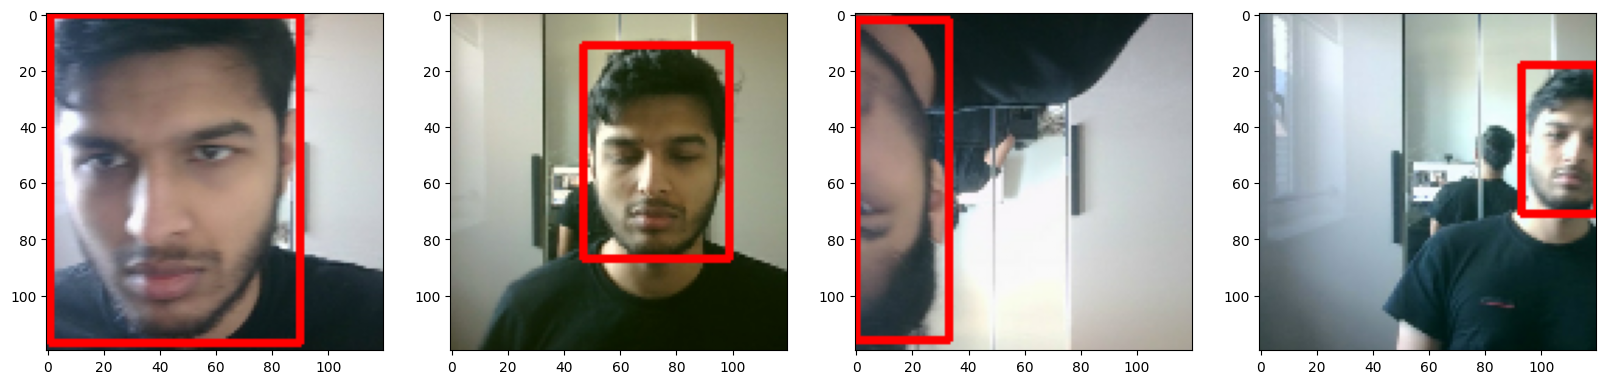

In [162]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)
    ax[idx].imshow(sample_image)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [16]:
vgg = VGG16(include_top=False)

In [17]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))

    vgg = VGG16(include_top=False)(input_layer)

    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [18]:
facetracker = build_model()

In [19]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
batches_per_epoch = len(train)
lr_decay = (1./0.75-1)/batches_per_epoch

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

/home/allen/myenv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [22]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true-w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [23]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [24]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
    
        class_labels, coords = y

        class_labels = tf.ensure_shape(class_labels, [None, 1])  
        coords = tf.ensure_shape(coords, [None, 4])

    
        with tf.GradientTape() as tape: 
            pred_classes, pred_coords = self.model(X, training=True)
    
            batch_classloss = self.closs(class_labels, pred_classes)
            batch_localizationloss = self.lloss(tf.cast(coords, tf.float32), pred_coords)
            total_loss = batch_localizationloss + 0.5 * batch_classloss
    
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.model.trainable_variables))
    
        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localizationloss,
            } 

    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        class_labels, coords = y
        
        class_labels = tf.ensure_shape(class_labels, [None, 1]) 
        coords = tf.ensure_shape(coords, [None, 4])
    
        pred_classes, pred_coords = self.model(X, training=False)
    
        batch_classloss = self.closs(class_labels, pred_classes)
        batch_localizationloss = self.lloss(tf.cast(coords, tf.float32), pred_coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
    
        return {
            "total_loss": total_loss,
            "class_loss": batch_classloss,
            "regress_loss": batch_localizationloss
        }

        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [25]:
model = FaceTracker(facetracker)

In [26]:
model.compile(opt, classloss, regressloss)

In [27]:
logdir='/mnt/c/logs'

In [28]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [29]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20


2025-04-05 22:30:13.511875: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
2025-04-05 22:30:23.530812: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 431 of 5000
2025-04-05 22:30:36.193819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1498 of 5000
2025-04-05 22:30:53.545652: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2162 of 5000
2025-04-05 22:31:03.530826: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2519 of 5000
2025-04-05 22:31:23.527311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buff

  3/473 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - class_loss: 0.3549 - regress_loss: 4.5168 - total_loss: 4.6942

I0000 00:00:1743888709.185083    2448 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


471/473 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - class_loss: 0.0643 - regress_loss: 0.3461 - total_loss: 0.3783

2025-04-05 22:32:12.436009: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3', 8 bytes spill stores, 8 bytes spill loads

2025-04-05 22:32:12.956794: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 12 bytes spill stores, 12 bytes spill loads

2025-04-05 22:32:13.462330: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 4 bytes spill stores, 4 bytes spill loads

2025-04-05 22:32:13.931553: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1083', 356 bytes spill stores, 356 bytes spill loads



473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - class_loss: 0.0641 - regress_loss: 0.3452 - total_loss: 0.3773

2025-04-05 22:32:28.194447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 292 of 5000
2025-04-05 22:32:38.187333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 740 of 5000
2025-04-05 22:32:38.858859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 151s 112ms/step - class_loss: 0.0640 - regress_loss: 0.3446 - total_loss: 0.3765 - val_class_loss: 0.0013 - val_regress_loss: 0.0068 - val_total_loss: 0.0074
Epoch 2/20


2025-04-05 22:32:52.286001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 598 of 5000
2025-04-05 22:33:12.298196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1587 of 5000
2025-04-05 22:33:22.292468: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2076 of 5000
2025-04-05 22:33:42.304419: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3023 of 5000
2025-04-05 22:33:52.301979: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3455 of 5000
2025-04-05 22:33:56.641722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - class_loss: 0.0213 - regress_loss: 0.0961 - total_loss: 0.1067

2025-04-05 22:34:32.047360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 623 of 5000
2025-04-05 22:34:34.822909: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - class_loss: 0.0213 - regress_loss: 0.0961 - total_loss: 0.1068 - val_class_loss: 3.7915e-05 - val_regress_loss: 0.0207 - val_total_loss: 0.0208
Epoch 3/20


2025-04-05 22:34:46.148260: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 623 of 5000
2025-04-05 22:34:56.133608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1302 of 5000
2025-04-05 22:35:06.140316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1867 of 5000
2025-04-05 22:35:18.275334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - class_loss: 0.0189 - regress_loss: 0.0614 - total_loss: 0.0709

2025-04-05 22:35:51.972122: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 462 of 5000
2025-04-05 22:35:58.071582: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 83s 86ms/step - class_loss: 0.0188 - regress_loss: 0.0612 - total_loss: 0.0706 - val_class_loss: 1.3716e-04 - val_regress_loss: 0.0037 - val_total_loss: 0.0037
Epoch 4/20


2025-04-05 22:36:09.347350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 820 of 5000
2025-04-05 22:36:19.349529: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1471 of 5000
2025-04-05 22:36:39.348733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2336 of 5000
2025-04-05 22:36:49.346604: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2828 of 5000
2025-04-05 22:36:59.365150: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3285 of 5000
2025-04-05 22:37:08.844832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - class_loss: 0.0214 - regress_loss: 0.0793 - total_loss: 0.0900

2025-04-05 22:37:41.734198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 618 of 5000
2025-04-05 22:37:45.478250: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 107s 80ms/step - class_loss: 0.0213 - regress_loss: 0.0790 - total_loss: 0.0896 - val_class_loss: 2.8745e-04 - val_regress_loss: 0.0421 - val_total_loss: 0.0422
Epoch 5/20


2025-04-05 22:37:56.806091: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 801 of 5000
2025-04-05 22:38:06.791895: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1466 of 5000
2025-04-05 22:38:26.802659: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2429 of 5000
2025-04-05 22:38:36.788574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2993 of 5000
2025-04-05 22:38:53.419836: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - class_loss: 0.0111 - regress_loss: 0.0419 - total_loss: 0.0474

2025-04-05 22:39:26.525704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 414 of 5000
2025-04-05 22:39:32.722328: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 107s 85ms/step - class_loss: 0.0110 - regress_loss: 0.0421 - total_loss: 0.0476 - val_class_loss: 1.0799e-04 - val_regress_loss: 0.0095 - val_total_loss: 0.0095
Epoch 6/20


2025-04-05 22:39:44.057389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 899 of 5000
2025-04-05 22:39:54.059925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1491 of 5000
2025-04-05 22:40:14.052549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2690 of 5000


  1/473 ━━━━━━━━━━━━━━━━━━━━ 6:26:35 49s/step - class_loss: 4.7717e-04 - regress_loss: 0.2444 - total_loss: 0.2446

2025-04-05 22:40:22.978818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - class_loss: 0.0093 - regress_loss: 0.0341 - total_loss: 0.0387

2025-04-05 22:40:59.109416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 607 of 5000
2025-04-05 22:41:02.202939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 90s 86ms/step - class_loss: 0.0094 - regress_loss: 0.0340 - total_loss: 0.0387 - val_class_loss: 1.3401e-04 - val_regress_loss: 0.0044 - val_total_loss: 0.0044
Epoch 7/20


2025-04-05 22:41:13.568924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 633 of 5000
2025-04-05 22:41:23.561537: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1141 of 5000
2025-04-05 22:41:33.566089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1731 of 5000
2025-04-05 22:41:53.574266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2788 of 5000
2025-04-05 22:42:03.579864: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3253 of 5000
2025-04-05 22:42:09.263182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 100s 72ms/step - class_loss: 0.0230 - regress_loss: 0.0999 - total_loss: 0.1114 - val_class_loss: 0.0933 - val_regress_loss: 0.2447 - val_total_loss: 0.2914
Epoch 8/20


2025-04-05 22:42:55.336364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 505 of 5000
2025-04-05 22:43:13.343737: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1819 of 5000
2025-04-05 22:43:23.332760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2282 of 5000
2025-04-05 22:43:43.326119: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3278 of 5000
2025-04-05 22:43:53.326006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3772 of 5000
2025-04-05 22:43:53.499591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.0131 - regress_loss: 0.0442 - total_loss: 0.0508

2025-04-05 22:44:29.382832: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 563 of 5000
2025-04-05 22:44:32.748889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 111s 85ms/step - class_loss: 0.0131 - regress_loss: 0.0440 - total_loss: 0.0506 - val_class_loss: 4.1408e-05 - val_regress_loss: 0.0028 - val_total_loss: 0.0028
Epoch 9/20


2025-04-05 22:44:44.008911: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 714 of 5000
2025-04-05 22:44:54.008576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1361 of 5000
2025-04-05 22:45:03.993062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1928 of 5000
2025-04-05 22:45:16.789483: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2630 of 5000


  1/473 ━━━━━━━━━━━━━━━━━━━━ 6:57:51 53s/step - class_loss: 0.0069 - regress_loss: 0.0114 - total_loss: 0.0148

2025-04-05 22:45:26.897907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - class_loss: 0.0064 - regress_loss: 0.0205 - total_loss: 0.0237

2025-04-05 22:46:02.895299: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 550 of 5000
2025-04-05 22:46:06.483800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 94s 86ms/step - class_loss: 0.0064 - regress_loss: 0.0205 - total_loss: 0.0237 - val_class_loss: 5.8057e-05 - val_regress_loss: 0.0024 - val_total_loss: 0.0024
Epoch 10/20


2025-04-05 22:46:17.875754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 758 of 5000
2025-04-05 22:46:37.855076: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1471 of 5000
2025-04-05 22:46:47.859046: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2149 of 5000
2025-04-05 22:46:57.856223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2651 of 5000
2025-04-05 22:47:17.857269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3668 of 5000
2025-04-05 22:47:20.223962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.0063 - regress_loss: 0.0212 - total_loss: 0.0244

2025-04-05 22:47:56.161458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 575 of 5000
2025-04-05 22:47:59.965647: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 113s 86ms/step - class_loss: 0.0063 - regress_loss: 0.0212 - total_loss: 0.0244 - val_class_loss: 4.1222e-04 - val_regress_loss: 0.0062 - val_total_loss: 0.0065
Epoch 11/20


2025-04-05 22:48:13.026198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 700 of 5000
2025-04-05 22:48:31.357098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1524 of 5000
2025-04-05 22:48:41.353805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2203 of 5000
2025-04-05 22:49:01.336099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3142 of 5000
2025-04-05 22:49:09.854533: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 106s 78ms/step - class_loss: 0.0064 - regress_loss: 0.0264 - total_loss: 0.0296 - val_class_loss: 3.3086e-06 - val_regress_loss: 0.0033 - val_total_loss: 0.0033
Epoch 12/20


2025-04-05 22:49:58.871410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 674 of 5000
2025-04-05 22:50:16.935806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2721 of 5000
2025-04-05 22:50:19.612145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - class_loss: 0.0070 - regress_loss: 0.0284 - total_loss: 0.0319

2025-04-05 22:50:55.872225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 563 of 5000
2025-04-05 22:50:59.814334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 74s 87ms/step - class_loss: 0.0070 - regress_loss: 0.0283 - total_loss: 0.0318 - val_class_loss: 2.2303e-05 - val_regress_loss: 0.0062 - val_total_loss: 0.0062
Epoch 13/20


2025-04-05 22:51:11.112635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 527 of 5000
2025-04-05 22:51:21.125501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1035 of 5000
2025-04-05 22:51:31.117429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1438 of 5000
2025-04-05 22:51:41.107511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1931 of 5000
2025-04-05 22:52:01.124706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2717 of 5000
2025-04-05 22:52:11.122554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may tak

472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - class_loss: 0.0080 - regress_loss: 0.0315 - total_loss: 0.0355

2025-04-05 22:52:58.560660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 452 of 5000
2025-04-05 22:53:03.504602: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 124s 82ms/step - class_loss: 0.0080 - regress_loss: 0.0313 - total_loss: 0.0353 - val_class_loss: 1.3755e-05 - val_regress_loss: 0.0098 - val_total_loss: 0.0098
Epoch 14/20


2025-04-05 22:53:14.784386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 747 of 5000
2025-04-05 22:53:24.765849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1184 of 5000
2025-04-05 22:53:44.789890: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2139 of 5000
2025-04-05 22:53:54.790351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2614 of 5000
2025-04-05 22:54:14.784802: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3622 of 5000
2025-04-05 22:54:17.833838: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.0183 - regress_loss: 0.0882 - total_loss: 0.0973

2025-04-05 22:54:53.507167: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 618 of 5000
2025-04-05 22:54:56.308498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 113s 84ms/step - class_loss: 0.0182 - regress_loss: 0.0878 - total_loss: 0.0969 - val_class_loss: 4.8236e-07 - val_regress_loss: 0.0150 - val_total_loss: 0.0150
Epoch 15/20


2025-04-05 22:55:07.635074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 949 of 5000
2025-04-05 22:55:27.125503: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.0059 - regress_loss: 0.0248 - total_loss: 0.0277

2025-04-05 22:56:02.768598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 553 of 5000
2025-04-05 22:56:06.473253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 70s 86ms/step - class_loss: 0.0058 - regress_loss: 0.0247 - total_loss: 0.0276 - val_class_loss: 7.2217e-06 - val_regress_loss: 0.0046 - val_total_loss: 0.0046
Epoch 16/20


2025-04-05 22:56:17.820744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 629 of 5000
2025-04-05 22:56:37.825778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1344 of 5000
2025-04-05 22:56:47.821349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2033 of 5000
2025-04-05 22:56:57.827125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2538 of 5000
2025-04-05 22:57:17.837009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3497 of 5000
2025-04-05 22:57:24.230458: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - class_loss: 0.0037 - regress_loss: 0.0143 - total_loss: 0.0162

2025-04-05 22:58:00.335619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 527 of 5000
2025-04-05 22:58:05.117032: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 119s 89ms/step - class_loss: 0.0037 - regress_loss: 0.0143 - total_loss: 0.0161 - val_class_loss: 1.0166e-05 - val_regress_loss: 0.0125 - val_total_loss: 0.0125
Epoch 17/20


2025-04-05 22:58:16.480020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 523 of 5000
2025-04-05 22:58:26.472534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1166 of 5000
2025-04-05 22:58:36.482859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1620 of 5000
2025-04-05 22:58:56.456142: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2560 of 5000
2025-04-05 22:59:06.476636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3287 of 5000
2025-04-05 22:59:12.502882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - class_loss: 0.0023 - regress_loss: 0.0086 - total_loss: 0.0098

2025-04-05 22:59:48.190445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 734 of 5000
2025-04-05 22:59:49.111447: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 104s 80ms/step - class_loss: 0.0023 - regress_loss: 0.0086 - total_loss: 0.0097 - val_class_loss: 8.4686e-05 - val_regress_loss: 0.0038 - val_total_loss: 0.0038
Epoch 18/20


2025-04-05 23:00:00.398352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 518 of 5000
2025-04-05 23:00:10.403991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1253 of 5000
2025-04-05 23:00:20.383352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3645 of 5000
2025-04-05 23:00:20.710729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - class_loss: 0.0035 - regress_loss: 0.0118 - total_loss: 0.0136

2025-04-05 23:00:56.846451: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 587 of 5000
2025-04-05 23:01:00.661574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 72s 87ms/step - class_loss: 0.0035 - regress_loss: 0.0118 - total_loss: 0.0135 - val_class_loss: 4.4598e-06 - val_regress_loss: 0.0014 - val_total_loss: 0.0014
Epoch 19/20


2025-04-05 23:01:11.898238: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 533 of 5000
2025-04-05 23:01:21.899266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 990 of 5000
2025-04-05 23:01:31.895702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1412 of 5000
2025-04-05 23:01:44.801584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1974 of 5000
2025-04-05 23:02:01.919028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2783 of 5000
2025-04-05 23:02:11.898750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take

  1/473 ━━━━━━━━━━━━━━━━━━━━ 10:31:55 80s/step - class_loss: 8.6777e-04 - regress_loss: 0.0218 - total_loss: 0.0222

2025-04-05 23:02:22.019152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


472/473 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - class_loss: 0.0035 - regress_loss: 0.0135 - total_loss: 0.0152

2025-04-05 23:02:55.453785: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 439 of 5000
2025-04-05 23:03:01.888065: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 121s 87ms/step - class_loss: 0.0035 - regress_loss: 0.0135 - total_loss: 0.0152 - val_class_loss: 2.5031e-05 - val_regress_loss: 0.0143 - val_total_loss: 0.0143
Epoch 20/20


2025-04-05 23:03:13.194245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 780 of 5000
2025-04-05 23:03:23.184972: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 1399 of 5000
2025-04-05 23:03:43.197190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 2576 of 5000
2025-04-05 23:03:53.188966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3161 of 5000
2025-04-05 23:04:06.313643: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:19: Filling up shuffle buffer (this may take a while): 3700 of 5000
2025-04-05 23:04:07.911606: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - class_loss: 0.0091 - regress_loss: 0.0417 - total_loss: 0.0462

2025-04-05 23:04:41.472379: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 666 of 5000
2025-04-05 23:04:43.704293: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


473/473 ━━━━━━━━━━━━━━━━━━━━ 102s 78ms/step - class_loss: 0.0091 - regress_loss: 0.0416 - total_loss: 0.0461 - val_class_loss: 6.1660e-06 - val_regress_loss: 0.0041 - val_total_loss: 0.0041


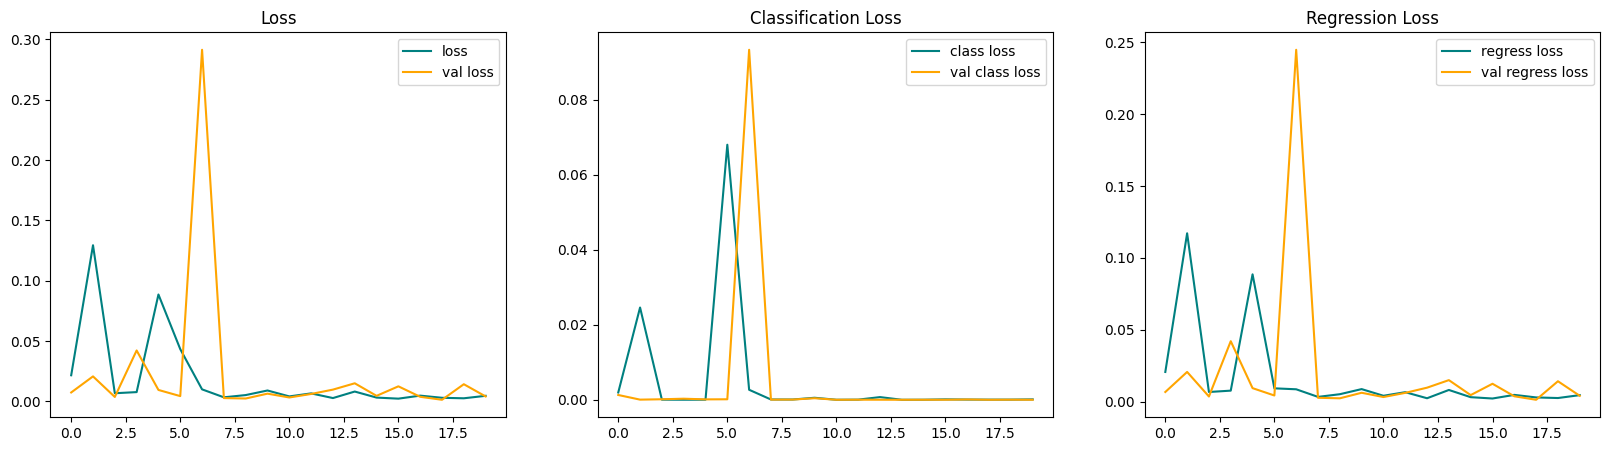

In [30]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [31]:
test_data = test.as_numpy_iterator()

In [32]:
test_sample = test_data.next()

2025-04-05 23:16:46.281386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 347 of 5000
2025-04-05 23:16:56.313235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 812 of 5000
2025-04-05 23:16:57.315385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


In [35]:
print(test_sample)

(array([[[[3.52879912e-01, 3.55330884e-01, 3.66237760e-01],
         [3.73406857e-01, 3.54411751e-01, 3.75857830e-01],
         [3.85968149e-01, 3.88112754e-01, 4.61948544e-01],
         ...,
         [4.72426489e-02, 8.64583328e-02, 8.25367644e-02],
         [4.31372561e-02, 8.23529437e-02, 7.84313753e-02],
         [4.55269590e-02, 8.47426504e-02, 8.08210820e-02]],

        [[3.58823538e-01, 3.63725483e-01, 3.58700991e-01],
         [3.78308833e-01, 3.68995100e-01, 3.75367641e-01],
         [3.73529404e-01, 3.69056374e-01, 4.21507359e-01],
         ...,
         [4.79779430e-02, 8.71936306e-02, 8.32720622e-02],
         [4.70588244e-02, 8.62745121e-02, 8.23529437e-02],
         [5.09803928e-02, 9.01960805e-02, 8.62745121e-02]],

        [[3.70098025e-01, 3.72549027e-01, 3.80392164e-01],
         [3.76899511e-01, 3.69056374e-01, 3.81801456e-01],
         [3.64399523e-01, 3.63909304e-01, 3.95281851e-01],
         ...,
         [4.31372561e-02, 8.23529437e-02, 7.84313753e-02],
         

In [33]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


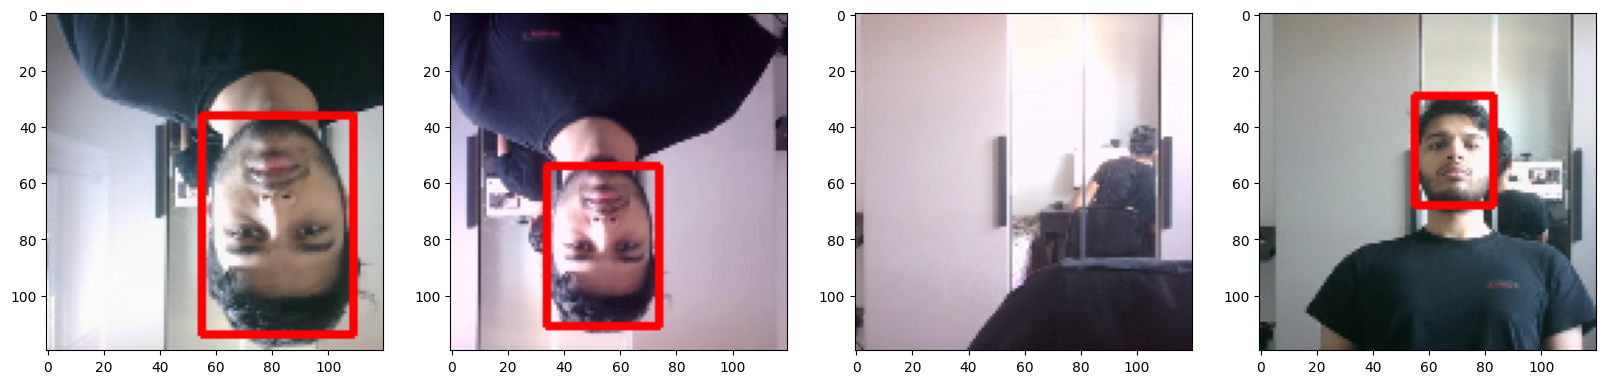

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_image = sample_image.copy()
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                      (255,0,0), 2)
    ax[idx].imshow(sample_image)

In [41]:
from tensorflow.keras.models import load_model

In [44]:
facetracker.save('facetracker.keras')

In [5]:
from tensorflow.keras.models import load_model
facetracker = load_model('facetracker.h5')

I0000 00:00:1743940533.955296     816 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [ ]:
cap = cv2.VideoCapture(cv2.CAP_V4L2)
cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc('M', 'J', 'P', 'G'))
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

I0000 00:00:1743940556.287847    1144 service.cc:152] XLA service 0x7f653400a9c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743940556.287872    1144 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-04-06 12:55:56.305840: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743940556.378772    1144 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


I0000 00:00:1743940557.605818    1144 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━